# [Sentiment Analysis on Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews)

## Description

>"There's a thin line between likably old-fashioned and fuddy-duddy, and The Count of Monte Cristo ... never quite settles on either side."

>The Rotten Tomatoes movie review dataset is a corpus of movie reviews used for sentiment analysis, originally collected by Pang and Lee [1]. In their work on sentiment treebanks, Socher et al. [2] used Amazon's Mechanical Turk to create fine-grained labels for all parsed phrases in the corpus. This competition presents a chance to benchmark your sentiment-analysis ideas on the Rotten Tomatoes dataset. You are asked to label phrases on a scale of five values: negative, somewhat negative, neutral, somewhat positive, positive. Obstacles like sentence negation, sarcasm, terseness, language ambiguity, and many others make this task very challenging.

>![Treebank](files/treebank.png)

>Kaggle is hosting this competition for the machine learning community to use for fun and practice. This competition was inspired by the work of Socher et al [2]. We encourage participants to explore the accompanying (and dare we say, fantastic) website that accompanies the paper:

>http://nlp.stanford.edu/sentiment/

>There you will find have source code, a live demo, and even an online interface to help train the model.

>[1] Pang and L. Lee. 2005. Seeing stars: Exploiting class relationships for sentiment categorization with respect to rating scales. In ACL, pages 115–124.

>[2] Recursive Deep Models for Semantic Compositionality Over a Sentiment Treebank, Richard Socher, Alex Perelygin, Jean Wu, Jason Chuang, Chris Manning, Andrew Ng and Chris Potts. Conference on Empirical Methods in Natural Language Processing (EMNLP 2013).

>Image credits: Popcorn - Maura Teague, http://www.flickr.com/photos/93496438@N06/



## Evaluation

>Submissions are evaluated on classification accuracy (the percent of labels that are predicted correctly) for every parsed phrase. The sentiment labels are:

>0 - negative  
>1 - somewhat negative  
2 - neutral  
3 - somewhat positive  
4 - positive  

>__Submission Format__

>For each phrase in the test set, predict a label for the sentiment. Your submission should have a header and look like the following:
```
>PhraseId,Sentiment  
156061,2  
156062,2  
156063,2  
...
```

## Data Description

>The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

>train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
test.tsv contains just phrases. You must assign a sentiment label to each phrase.
The sentiment labels are:

>0 - negative  
1 - somewhat negative  
2 - neutral  
3 - somewhat positive  
4 - positive  

This is my first experience with NLP in the scope of ML. There was a similar [Kaggle competition](https://www.kaggle.com/c/word2vec-nlp-tutorial) but I don't necessarily want to use Google's Word2Vec. 

Let's see what's up here. I'll first explore the data then go from there.

1. [Exploration](#exploration)
2. [Preprocessing](#preprocessing)
  1. [Contractions](#contractions)
  2. [Stop Words](#stopwords)
  3. [Character Parsing and One-hot Encoding](#char)
3. [Analysis](#analysis)

# <a name="exploration">Exploration</a>

In [1]:
### Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
### Import datasets
train = pd.read_csv('Data/train.tsv', sep='\t')
test = pd.read_csv('Data/test.tsv', sep='\t')

__Going through the usual motions here:__

In [3]:
train.head()

PhraseId  SentenceId                                             Phrase  \
0         1           1  A series of escapades demonstrating the adage ...   
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2

In [4]:
test.head()

PhraseId  SentenceId                                             Phrase
0    156061        8545  An intermittently pleasing but mostly routine ...
1    156062        8545  An intermittently pleasing but mostly routine ...
2    156063        8545                                                 An
3    156064        8545  intermittently pleasing but mostly routine effort
4    156065        8545         intermittently pleasing but mostly routine

In [5]:
train.describe(include='all')

PhraseId     SentenceId        Phrase      Sentiment
count   156060.000000  156060.000000        156060  156060.000000
unique            NaN            NaN        156060            NaN
top               NaN            NaN  the end zone            NaN
freq              NaN            NaN             1            NaN
mean     78030.500000    4079.732744           NaN       2.063578
std      45050.785842    2502.764394           NaN       0.893832
min          1.000000       1.000000           NaN       0.000000
25%      39015.750000    1861.750000           NaN       2.000000
50%      78030.500000    4017.000000           NaN       2.000000
75%     117045.250000    6244.000000           NaN       3.000000
max     156060.000000    8544.000000           NaN       4.000000

In [6]:
test.describe(include='all')

PhraseId    SentenceId Phrase
count    66292.00000  66292.000000  66292
unique           NaN           NaN  66292
top              NaN           NaN  Casey
freq             NaN           NaN      1
mean    189206.50000  10114.909144    NaN
std      19136.99636    966.787807    NaN
min     156061.00000   8545.000000    NaN
25%     172633.75000   9266.000000    NaN
50%     189206.50000  10086.000000    NaN
75%     205779.25000  10941.000000    NaN
max     222352.00000  11855.000000    NaN

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
PhraseId      66292 non-null int64
SentenceId    66292 non-null int64
Phrase        66292 non-null object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [9]:
# Do any features of NaNs?
train.isnull().any()

PhraseId      False
SentenceId    False
Phrase        False
Sentiment     False
dtype: bool

In [10]:
test.isnull().any()

PhraseId      False
SentenceId    False
Phrase        False
dtype: bool

Of course not...

__It seems everyone is pretty meh about movies:__

In [11]:
# s = 4
#train[train.Sentiment == s].shape
train.Sentiment.value_counts().sort_index()

0     7072
1    27273
2    79582
3    32927
4     9206
Name: Sentiment, dtype: int64

[Text(0,0.5,'Counts (%)'), Text(0.5,0,'Sentiment')]

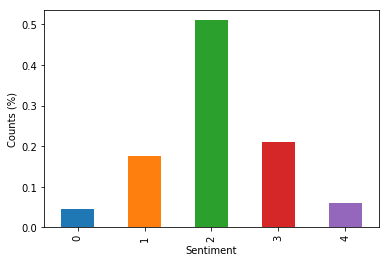

In [12]:
ax = train.Sentiment.value_counts(normalize=True).sort_index().plot(kind='bar')#, x='Sentiment', y='Counts (%)')
ax.set(xlabel="Sentiment", ylabel="Counts (%)")

__It seems each row/instance contains a unique PhraseId, and some number of PhraseIds are formed from a single SentenceId:__

In [13]:
# Number of unique sentences
train.SentenceId.values.max()

8544

In [14]:
# Number of unique phrases
train.PhraseId.values.max()

156060

__Anyway, let's look at the first SentenceId (PhraseId and SentenceId start at 1):__

In [15]:
sid1 = train[train['SentenceId'] == 1]
sid1

PhraseId  SentenceId                                             Phrase  \
0          1           1  A series of escapades demonstrating the adage ...   
1          2           1  A series of escapades demonstrating the adage ...   
2          3           1                                           A series   
3          4           1                                                  A   
4          5           1                                             series   
5          6           1  of escapades demonstrating the adage that what...   
6          7           1                                                 of   
7          8           1  escapades demonstrating the adage that what is...   
8          9           1                                          escapades   
9         10           1  demonstrating the adage that what is good for ...   
10        11           1                            demonstrating the adage   
11        12           1                                      demonstrating   
12        13           1                                          the adage   
13        14           1                                                the   
14        15           1                                              adage   
15        16           1                    that what is good for the goose   
16        17           1                                               that   
17        18           1                         what is good for the goose   
18        19           1                                               what   
19        20           1                              is good for the goose   
20        21           1                                                 is   
21        22           1                                 good for the goose   
22        23           1                                               good   
23        24           1                                      for the goose   
24        25           1                                                for   
25        26           1                                          the goose   
26        27           1                                              goose   
27        28           1  is also good for the gander , some of which oc...   
28        29           1  is also good for the gander , some of which oc...   
29        30           1                                            is also   
..       ...         ...                                                ...   
33        34           1  the gander , some of which occasionally amuses...   
34        35           1                                       the gander ,   
35        36           1                                         the gander   
36        37           1                                             gander   
37        38           1                                                  ,   
38        39           1  some of which occasionally amuses but none of ...   
39        40           1                                      some of which   
40        41           1                                               some   
41        42           1                                           of which   
42        43           1                                              which   
43        44           1  occasionally amuses but none of which amounts ...   
44        45           1                                       occasionally   
45        46           1  amuses but none of which amounts to much of a ...   
46        47           1                                             amuses   
47        48           1       but none of which amounts to much of a story   
48        49           1                                                but   
49        50           1           none of which amounts to much of a story   
50        51           1                                               none   
51        52           1                of which amoun

In [16]:
# sid1 "sorted" by length of Phrase
sid1.reindex(sid1.Phrase.str.len().sort_values().index)

PhraseId  SentenceId                                             Phrase  \
62        63           1                                                  .   
3          4           1                                                  A   
37        38           1                                                  ,   
56        57           1                                                 to   
6          7           1                                                 of   
20        21           1                                                 is   
48        49           1                                                but   
24        25           1                                                for   
13        14           1                                                the   
50        51           1                                               none   
40        41           1                                               some   
30        31           1                                               also   
22        23           1                                               good   
18        19           1                                               what   
16        17           1                                               that   
58        59           1                                               much   
14        15           1                                              adage   
42        43           1                                              which   
61        62           1                                              story   
26        27           1                                              goose   
4          5           1                                             series   
46        47           1                                             amuses   
36        37           1                                             gander   
54        55           1                                            amounts   
60        61           1                                            a story   
29        30           1                                            is also   
2          3           1                                           A series   
41        42           1                                           of which   
12        13           1                                          the adage   
8          9           1                                          escapades   
..       ...         ...                                                ...   
44        45           1                                       occasionally   
34        35           1                                       the gander ,   
39        40           1                                      some of which   
11        12           1                                      demonstrating   
23        24           1                                      for the goose   
57        58           1                                    much of a story   
55        56           1                                 to much of a story   
21        22           1                                 good for the goose   
19        20           1                              is good for the goose   
10        11           1                            demonstrating the adage   
17        18           1                         what is good for the goose   
53        54           1                         amounts to much of a story   
15        16           1                    that what is good for the goose   
52        53           1                   which amounts to much of a story   
51        52           1                of which amounts to much of a story   
49        50           1           none of which amounts to much of a story   
47        48           1       but none of which amounts to much of a story   
45        46           1  amuses but none of which amounts to much of a ...   
9         10           1  demonstrating the adage that

In [17]:
# Longest phrase in SentenceId=1
lp1 = sid1.Phrase.str.len().max().argmax()
print(lp1, sid1.Phrase.iloc[lp1])

0 A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .


The longest phrase in sid1 is also the first phrase. I wonder if that's true for all?

In [18]:
# Longest phrase in SentenceId=2
sid2 = train[train['SentenceId'] == 2]
lp2 = sid2.Phrase.str.len().max().argmax()
print(lp2, sid2.Phrase.iloc[0])

0 This quiet , introspective and entertaining independent is worth seeking .


In [19]:
# Longest phrase in SentenceId=3
sid3 = train[train['SentenceId'] == 3]
lp3 = sid3.Phrase.str.len().max().argmax()
print(lp3, sid3.Phrase.iloc[0])

0 Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .


Seems so.

__Let's look at the smallest unit of sentiment: single words.__

In [20]:
# Silence warning. drop() throws warning.
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None  # default='warn'

# Create DF of all single words in SentenceId and make them all lowercase
singlewords = train[train.Phrase.str.split().str.len() == 1]
#phrase = singlewords.Phrase.str.lower()
#singlewords.drop('Phrase', axis=1, inplace=True)
##singlewords['Phrase'] = phrase.str.lower()
#singlewords.insert(2, 'Phrase', phrase)
singlewords['Phrase'] = singlewords['Phrase'].str.lower()
singlewords.head()

PhraseId  SentenceId         Phrase  Sentiment
3          4           1              a          2
4          5           1         series          2
6          7           1             of          2
8          9           1      escapades          2
11        12           1  demonstrating          2

In [21]:
# Get value_counts() of single word phrases
singlewords_counts = singlewords.Phrase.value_counts()
singlewords_counts.head()

dreaming       1
outstanding    1
eternal        1
nationalist    1
conjures       1
Name: Phrase, dtype: int64

Unless I've done something wrong, it seems all phrases are unique. That is, there is a single PhraseID for "a", "what", etc regardless of how many times it shows up in a single SentenceId or how many SentenceIds contain that word. So one couldn't get the most used words, etc. from this dataset. We can at least (obviously) get the highest/lowest sentiment phrases/words from this dataset.

Sentiments from full dataset:

In [22]:
# FYI head and tail can be displayed simulaneaously via df.iloc[np.r_[0:5, -5:0]]
# From https://stackoverflow.com/questions/42504984/python-pandas-select-both-head-and-tail
train.sort_values(by='Sentiment').head()

PhraseId  SentenceId  \
55690      55691        2785   
148142    148143        8062   
148141    148142        8062   
59657      59658        3010   
137237    137238        7425   

                                                   Phrase  Sentiment  
55690   A derivative collection of horror and sci-fi c...          0  
148142  a plotline that 's as lumpy as two-day old por...          0  
148141  ... a plotline that 's as lumpy as two-day old...          0  
59657   you 're rooting for the film to hurry up and g...          0  
137237  is a movie so insecure about its capacity to e...          0

In [23]:
train.sort_values(by='Sentiment').tail()

PhraseId  SentenceId  \
146074    146075        7943   
132810    132811        7161   
146080    146081        7943   
37946      37947        1805   
147135    147136        8007   

                                                   Phrase  Sentiment  
146074  the talented cast alone will keep you watching...          4  
132810                   compelling supporting characters          4  
146080       keep you watching , as will the fight scenes          4  
37946   's as rude and profane as ever , always hilari...          4  
147135  that begins with the everyday lives of naval p...          4

Sentiments from single word dataset:

In [24]:
singlewords.sort_values(by='Sentiment').head()

PhraseId  SentenceId                  Phrase  Sentiment
21732      21733         971               worthless          0
42157      42158        2028                one-star          0
138709    138710        7516  soon-to-be-forgettable          0
95032      95033        4957                  bitchy          0
24420      24421        1110          disappointment          0

In [25]:
singlewords.sort_values(by='Sentiment').tail()

PhraseId  SentenceId       Phrase  Sentiment
3671       3672         138        fresh          4
36927     36928        1749   delightful          4
16397     16398         705  astonishing          4
362         363          13          joy          4
3293       3294         124     riveting          4

# <a name="preprocessing">Preprocessing</a>

### <a name="contractions">Maybe we can clean the data by expanding all contractions</a>

In [26]:
# Assume all contractions employ an apostrophe '
train.Phrase[train.Phrase.str.contains('\'')].head()

81    Even fans of Ismail Merchant 's work , I suspe...
82                 Even fans of Ismail Merchant 's work
86                           of Ismail Merchant 's work
87                              Ismail Merchant 's work
88                                   Ismail Merchant 's
Name: Phrase, dtype: object

Of course some apostrophes are for "...'s", but others should be "...n't", etc. Let's look at that now.

In [27]:
nt = 'n\'t'
snot = 'not' # PhraseId is already parsed with space between "does" and "n't", e.g.
NOT = train[train.Phrase.str.contains(nt)]
NOT.head()

PhraseId  SentenceId                                 Phrase  Sentiment
247       248           9  But it does n't leave you with much .          1
248       249           9      it does n't leave you with much .          1
249       250           9         does n't leave you with much .          1
250       251           9           does n't leave you with much          1
251       252           9                               does n't          1

In [28]:
# Need to parse words first
#train.Phrase[train.Phrase.str.contains(nt)].str.split().replace(nt,snot).head()#.str.join(' ').head()
# Just kidding:
NOT['Phrase'] = NOT['Phrase'].str.replace(nt, snot)
NOT.head()

PhraseId  SentenceId                                 Phrase  Sentiment
247       248           9  But it does not leave you with much .          1
248       249           9      it does not leave you with much .          1
249       250           9         does not leave you with much .          1
250       251           9           does not leave you with much          1
251       252           9                               does not          1

Neat. Now let's do this with all known contractions...

In [29]:
# n't, 've, 're, 'll, 'd, 'm, 's
# the 's could be tricky...
contractions = ['n\'t', '\'ve', '\'re', '\'ll', '\'d', '\'m', '\'s']
full = ['not', 'have', 'are', 'will', 'would', 'am', 'is']

#for c,f in zip(contractions,full):
#    train['Phrase'] = train['Phrase'].str.replace(c,f)

In [30]:
#train.Phrase[train.Phrase.str.contains('\'')]

Quotation marks remain, and abbrevations for decades. Maybe other things. 

But I just realized... Perhaps sentiment changes when contractions are used. Uh oh. Let's just not do the above...

### <a name="stopwords">Stop Words</a>

[Stop words](https://en.wikipedia.org/wiki/Stop_words) are common words that  may be removed from the dataset without loss of analysis potential.

### <a name="char">Perhaps we could analyze all PhraseIds at the character level</a>

That means we would need to split everything to individual characters and attempt [one-hot encoding](https://en.wikipedia.org/wiki/One-hot).

In [31]:
train.Phrase.head()

0    A series of escapades demonstrating the adage ...
1    A series of escapades demonstrating the adage ...
2                                             A series
3                                                    A
4                                               series
Name: Phrase, dtype: object

#### Create new DF with PhraseId: 'String' --> ['s', 't', 'r', ...]


In [32]:
# https://stackoverflow.com/questions/43848680/pandas-split-dataframe-column-for-every-character
#chars = train.Phrase.apply(lambda x: list(x))
#chars.head()
trainc = train.copy() # character
trainc['Phrase'] = trainc['Phrase'].str.lower().apply(lambda x: list(x))
trainc.Phrase.head()

0    [a,  , s, e, r, i, e, s,  , o, f,  , e, s, c, ...
1    [a,  , s, e, r, i, e, s,  , o, f,  , e, s, c, ...
2                             [a,  , s, e, r, i, e, s]
3                                                  [a]
4                                   [s, e, r, i, e, s]
Name: Phrase, dtype: object

In [33]:
# Longest phrase, number of characters
longest = trainc.Phrase.str.len().max()
longest

283

#### Create new DF with PhraseId: ['String', 'Str', ...] --> [ 'string', 'str---', ... ]

In [34]:
# Pad all phrases to match longest phrase
# If using SGD, I'm use this could be padded per minibatch rather than per dataset.
trainp = train.copy() # pad
trainp['Phrase'] = trainp['Phrase'].str.lower().str.pad(width=longest, side='right', fillchar=' ') #.apply(lambda x: x[0].ljust(longest, ' '))
#trainp.head()

In [35]:
trainp.Phrase.head()

0    a series of escapades demonstrating the adage ...
1    a series of escapades demonstrating the adage ...
2    a series                                      ...
3    a                                             ...
4    series                                        ...
Name: Phrase, dtype: object

#### Create new DF with PhraseId: ['String', 'Str', ...] --> [ ['s', 't','r','i','n','g'], ['s','t','r', ' ',' ',' '], ... ]

In [36]:
trainpc = trainp.copy() # pad and character
trainpc['Phrase'] = trainpc['Phrase'].apply(lambda x: list(x))
trainpc.Phrase.head()

0    [a,  , s, e, r, i, e, s,  , o, f,  , e, s, c, ...
1    [a,  , s, e, r, i, e, s,  , o, f,  , e, s, c, ...
2    [a,  , s, e, r, i, e, s,  ,  ,  ,  ,  ,  ,  , ...
3    [a,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ...
4    [s, e, r, i, e, s,  ,  ,  ,  ,  ,  ,  ,  ,  , ...
Name: Phrase, dtype: object

### Create one-hot matrix

What I am trying to do here: take all Phrases and transform them into a one-hot matrix. To me, this is effectively an "image" that can hopefully be flattened and processed from there. This does increase the dimensions a lot, though... I think this is a common problem though.

In [37]:
# https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python
t = trainpc.Phrase.iloc[0]
print(t)

['a', ' ', 's', 'e', 'r', 'i', 'e', 's', ' ', 'o', 'f', ' ', 'e', 's', 'c', 'a', 'p', 'a', 'd', 'e', 's', ' ', 'd', 'e', 'm', 'o', 'n', 's', 't', 'r', 'a', 't', 'i', 'n', 'g', ' ', 't', 'h', 'e', ' ', 'a', 'd', 'a', 'g', 'e', ' ', 't', 'h', 'a', 't', ' ', 'w', 'h', 'a', 't', ' ', 'i', 's', ' ', 'g', 'o', 'o', 'd', ' ', 'f', 'o', 'r', ' ', 't', 'h', 'e', ' ', 'g', 'o', 'o', 's', 'e', ' ', 'i', 's', ' ', 'a', 'l', 's', 'o', ' ', 'g', 'o', 'o', 'd', ' ', 'f', 'o', 'r', ' ', 't', 'h', 'e', ' ', 'g', 'a', 'n', 'd', 'e', 'r', ' ', ',', ' ', 's', 'o', 'm', 'e', ' ', 'o', 'f', ' ', 'w', 'h', 'i', 'c', 'h', ' ', 'o', 'c', 'c', 'a', 's', 'i', 'o', 'n', 'a', 'l', 'l', 'y', ' ', 'a', 'm', 'u', 's', 'e', 's', ' ', 'b', 'u', 't', ' ', 'n', 'o', 'n', 'e', ' ', 'o', 'f', ' ', 'w', 'h', 'i', 'c', 'h', ' ', 'a', 'm', 'o', 'u', 'n', 't', 's', ' ', 't', 'o', ' ', 'm', 'u', 'c', 'h', ' ', 'o', 'f', ' ', 'a', ' ', 's', 't', 'o', 'r', 'y', ' ', '.', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',

In [38]:
pd.get_dummies(t).head()

,  .  a  b  c  d  e  f  g ...  m  n  o  p  r  s  t  u  w  y
0  0  0  0  1  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
1  1  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  1  0  0  0  0
3  0  0  0  0  0  0  0  1  0  0 ...  0  0  0  0  0  0  0  0  0  0
4  0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  1  0  0  0  0  0

[5 rows x 23 columns]

I could attempt to do something like the above for all instances but it will be tedious. I'll employ sklearn instead.

In [39]:
from sklearn.preprocessing import OneHotEncoder

In [40]:
#onehot = OneHotEncoder()
#onehot.fit(trainpc.Phrase)

In [41]:
# https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list
# The below cannot be done on full df due to Memory
df = trainp.copy().head()
df.drop('Phrase', 1).join(
    pd.get_dummies(
        pd.DataFrame(df.Phrase.tolist()).stack()
    ).astype(int).sum(level=0)
)

PhraseId  SentenceId  Sentiment  \
0         1           1          1   
1         2           1          2   
2         3           1          2   
3         4           1          2   
4         5           1          2   

   a                                                                                                                                                                                                                                                                                            \
0                                                  0                                                                                                                                                                                                                                             
1                                                  0                                                                                                                                                                                                                                             
2                                                  0                                                                                                                                                                                                                                             
3                                                  1                                                                                                                                                                                                                                             
4                                                  0                                                                                                                                                                                                                                             

   a series                                                                                                                                                                                                                                                                                     \
0                                                  0                                                                                                                                                                                                                                             
1                                                  0                                                                                                                                                                                                                                             
2                                                  1                                                                                                                                                                                                                                             
3                                                  0                                                                                                                                                                                                                                             
4                                                  0                                                                                                                                                                                                                                             

   a series of escapades demonstrating the adage that what is good for the goose                                                                                                                                                                                                                \
0 

In [42]:
# https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
df = trainp.copy().head(2)
#for index,row in df.iterrows():
#    print(list(row['Phrase']))
for row in df.itertuples():
    #print(list(getattr(row, 'Phrase')))
    print(pd.get_dummies(list(getattr(row, 'Phrase'))))

        ,  .  a  b  c  d  e  f  g ...  m  n  o  p  r  s  t  u  w  y
0    0  0  0  1  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
1    1  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
2    0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  1  0  0  0  0
3    0  0  0  0  0  0  0  1  0  0 ...  0  0  0  0  0  0  0  0  0  0
4    0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  1  0  0  0  0  0
5    0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
6    0  0  0  0  0  0  0  1  0  0 ...  0  0  0  0  0  0  0  0  0  0
7    0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  1  0  0  0  0
8    1  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
9    0  0  0  0  0  0  0  0  0  0 ...  0  0  1  0  0  0  0  0  0  0
10   0  0  0  0  0  0  0  0  1  0 ...  0  0  0  0  0  0  0  0  0  0
11   1  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
12   0  0  0  0  0  0  0  1  0  0 ...  0  0  0  0  0  0  0  0  0  0
13   0  0  0  0  0  0  0  0  0  0 ...  0  0  0  

In [43]:
# Create string with available ascii characters
import string
printable = string.printable
print(repr(printable))
printable2 = string.digits + string.ascii_lowercase + string.punctuation + ' '#string.whitespace
print(repr(printable2))

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'
'0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '


In [44]:
s = np.zeros((longest, len(printable2))).astype(int)
#for j in range(len(printable2)):
#    for i in range(longest):
#        print(s[i][j])
empty = pd.DataFrame(s, columns=list(printable2))
empty.head()

0  1  2  3  4  5  6  7  8  9 ...  \  ]  ^  _  `  {  |  }  ~   
0  0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
1  0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
3  0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
4  0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0

[5 rows x 69 columns]

In [45]:
# From http://fastml.com/how-to-use-pd-dot-get-dummies-with-the-test-set/
def add_missing_dummy_columns( d, columns ):
    missing_cols = set( columns ) - set( d.columns )
    for c in missing_cols:
        d[c] = 0

def fix_columns( d, columns ):  

    add_missing_dummy_columns( d, columns )

    # make sure we have all the columns we need
    assert( set( columns ) - set( d.columns ) == set())

    extra_cols = set( d.columns ) - set( columns )
    if extra_cols:
        print("extra columns:", extra_cols)

    d = d[ columns ]
    return d

#fix_columns(df, list(printable2))

In [46]:
#df.Phrase.apply(lambda x: list(x)).iloc[0]

In [47]:
onehot = np.array([])
for row in df.itertuples():
    #print(pd.get_dummies(list(getattr(row,'Phrase')),columns=list(printable2)))
    # List of unique characters in PhraseId
    d = set(list(getattr(row, 'Phrase')))
    # List of unique (all) characters in printable2
    p2 = set(printable2)
    
    #a = np.array([])
    #for i in set(d):
    #    if i 

In [48]:
d = set(list(getattr(row, 'Phrase')))
print(d)
p2 = set(printable2)
print(p2)

{'h', ' ', 'o', 'n', 'e', 'g', 'f', 't', 'i', 'd', 'c', 'w', 's', 'a', 'm', 'p', 'r'}
{'7', '=', 'k', ' ', 'j', '8', 'f', '`', '>', '(', '{', '-', 'b', 'y', '&', '}', 'h', 'q', '$', '0', 'l', '4', '<', '#', ':', '[', ',', '?', '^', 'w', '%', '3', 'a', 's', '.', '/', '|', 'm', 'n', ')', '+', '2', 'g', '\\', "'", '6', 'd', 'i', 't', '5', 'p', 'o', 'r', '"', '9', 'u', '*', '@', '~', 'z', '!', 'c', '_', 'v', 'e', '1', 'x', ';', ']'}


In [49]:
# Add 1 to array if element is in printable2, else add 0.
# Will throw warning. Probably ijupyter kernal problem.
def Map(d):
    z = np.array([], dtype=np.uint8)#np.zeros(len(p2)).astype(int)
    a = np.array([])#, dtype=np.int)
    for i in p2:
        if i in a: 
            continue
        elif i in d: 
            z = np.append(z, 1)#.astype(int)
            a = np.append(a, i)
        else: 
            z = np.append(z, 0)#.astype(int)
        
    #print(a)
    #print(z)
    return z

Map(d)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0])

In [50]:
for row in df.itertuples():
    print(pd.get_dummies(list(getattr(row, 'Phrase'))))

        ,  .  a  b  c  d  e  f  g ...  m  n  o  p  r  s  t  u  w  y
0    0  0  0  1  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
1    1  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
2    0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  1  0  0  0  0
3    0  0  0  0  0  0  0  1  0  0 ...  0  0  0  0  0  0  0  0  0  0
4    0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  1  0  0  0  0  0
5    0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
6    0  0  0  0  0  0  0  1  0  0 ...  0  0  0  0  0  0  0  0  0  0
7    0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  1  0  0  0  0
8    1  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
9    0  0  0  0  0  0  0  0  0  0 ...  0  0  1  0  0  0  0  0  0  0
10   0  0  0  0  0  0  0  0  1  0 ...  0  0  0  0  0  0  0  0  0  0
11   1  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
12   0  0  0  0  0  0  0  1  0  0 ...  0  0  0  0  0  0  0  0  0  0
13   0  0  0  0  0  0  0  0  0  0 ...  0  0  0  

In [51]:
# To hold onehot maps and associated other data
onehots = pd.DataFrame(columns=('PhraseId','SentenceId','One-hot','Sentiment'))
# To hold onehot map
#onehot = pd.DataFrame(columns=set(printable2))

In [52]:
for index,row in df.iterrows():
    
    # To hold onehot map
    onehot = pd.DataFrame(columns=set(printable2))
    
    phraseid = row.PhraseId
    sentenceid = row.SentenceId
    # Break Phrase up into characters and reshape form (y,) to (y,1)
    phrase = np.reshape(np.array(list(row.Phrase)), (len(row.Phrase),1))
    sentiment = row.Sentiment
    
    #print(phrase.shape)
    #print(phraseid, sentenceid, phrase, sentiment)
    
    for char in row:
        None

# Wait, why am I trying to make it a (283x69) array with values of 0 and 1 ... when I get just as much data in a (283,1) array with values of 0-68?  

So I don't need one-hots?

Let's try something else:

For each instance in train,test:  
1. PhraseId from single string to padded array of single characters
2. Map character to number from 0-len(printable)
3. Normalize mapped characters from 0-len(printable) to 0-1
3. Put back into df

In [53]:
### 1. PhraseId from single string to padded array of single characters
# Longest phrase, in number of characters, in either train or test
pad = max(train.Phrase.str.len().max(), test.Phrase.str.len().max())

# Make new df with padded lowercase PhraseId. Assume letter case doesn't matter.
# Create new DF with PhraseId: 
# ['String1', 'Str2', ...] --> 
#   [ ['s', 't','r','i','n','g','1'], ['s','t','r','2',' ',' ',' '], ... ]
train2 = train.copy()
train2['Phrase'] = train2['Phrase'].str.lower(). \
                      str.pad(width=pad,side='right',fillchar=' '). \
                      apply(lambda x: list(x))

test2 = test.copy()
test2['Phrase'] = test2['Phrase'].str.lower(). \
                      str.pad(width=pad,side='right',fillchar=' '). \
                      apply(lambda x: list(x))

train2.head()

PhraseId  SentenceId                                             Phrase  \
0         1           1  [a,  , s, e, r, i, e, s,  , o, f,  , e, s, c, ...   
1         2           1  [a,  , s, e, r, i, e, s,  , o, f,  , e, s, c, ...   
2         3           1  [a,  , s, e, r, i, e, s,  ,  ,  ,  ,  ,  ,  , ...   
3         4           1  [a,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ,  , ...   
4         5           1  [s, e, r, i, e, s,  ,  ,  ,  ,  ,  ,  ,  ,  , ...   

   Sentiment  
0          1  
1          2  
2          2  
3          2  
4          2

In [54]:
### 2. Map character to number from 0-len(printable)
# Create string with available ascii characters
import string
printable = string.digits + string.ascii_lowercase + string.punctuation + ' '
#print('ASCII = '+repr(printable))

# Keys are ASCII characters
keys = list(printable)#.sort()
'''
# Values are normalized floats: [0., 0.01470558, ..., 1.]
values = np.divide(range(len(printable)), len(printable)-1)
dict = {}
for i in range(len(keys)):
    dict[keys[i]] = values[i]
#print(dict)    
'''
# Actually... having float values doesn't make sense.
# Instead make each value an np.zeros with 1 at appropriate index
#empty = np.zeros(len(printable)).astype(int)
#values = np.array([]).astype(int)
values = [] #np.zeros(len(printable)).astype(int)
#for i,c in enumerate(keys):
for i in range(len(printable)):
    value = np.zeros(len(printable)).astype(int)
    value[i] = 1
    #values = np.append(values, np.array([value]), axis=1)
    #values[i] = value
    values.append(np.asarray(value).astype(int))
dict = {}
for i in range(len(keys)):
    dict[keys[i]] = values[i]

# Loop through dataframes
tr2 = train2.copy().head()
te2 = test2.copy().head()
# index, row
for (traini,trainr), (testi,testr) in zip(tr2.iterrows(), te2.iterrows()):
    #trainphraseid = trainr.PhraseId
    #trainsentenceid = trainr.SentenceId
    #trainphrase = trainr.Phrase
    #trainsentiment = trainr.Sentiment
    #tr2.Phrase.replace(dict)
    None
    

In [55]:
#s = np.zeros((longest, len(printable2))).astype(int)
# list of dataframes
onehots_list = []

for i,row in tr2.iterrows():
    '''
    empty = pd.DataFrame(s, columns=list(printable2))
    for char in row.Phrase:
        #print(i,np.argmax(dict[char]))
        empty.iloc[i,np.argmax(dict[char])] = 1
    tr2['One-shots'] = empty.copy
    '''
    onehot = pd.DataFrame(columns=list(printable))
    for i,char in enumerate(row.Phrase):
        onehot.loc[i] = dict[char]
        
    onehots_list.append(onehot.fillna(0)) # For whatever reason NaNs were present(?). Found via sns.heatmap error.

# array of arrays. Does not retain columns/chars
onehots_array = np.array([i.values for i in onehots_list])

# flatten arrays
onehots_flat = np.array([i.flatten() for i in onehots_array])

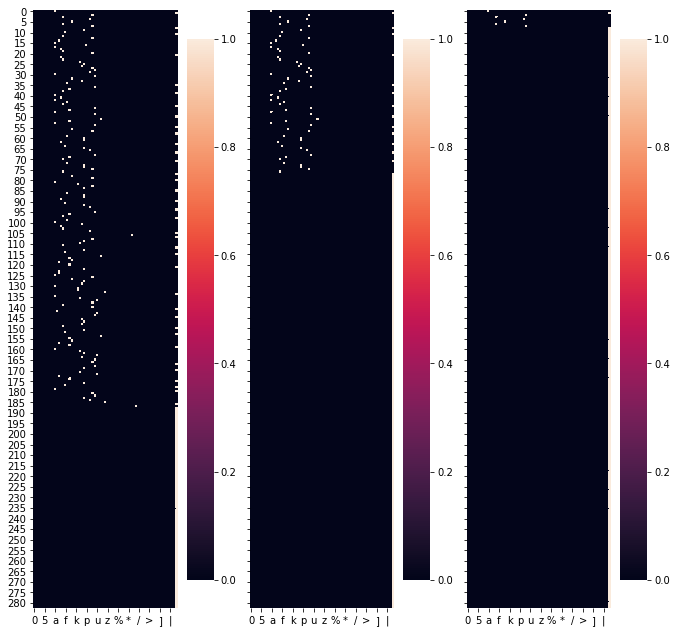

In [56]:
import seaborn as sns
plt.figure(figsize=(11, 11))
f, ax = plt.subplots(1,3, sharey=True, figsize=(11,11))
sns.heatmap(onehots_list[0], ax=ax[0])
sns.heatmap(onehots_list[1], ax=ax[1])
sns.heatmap(onehots_list[2], ax=ax[2])
#plt.show()

In [57]:
onehots_list[0].columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd',
       'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
       's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&',
       ''', '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>',
       '?', '@', '[', '\', ']', '^', '_', '`', '{', '|', '}', '~', ' '],
      dtype='object')

In [58]:
lens = [len(sid1), len(sid2), len(sid3)]
lenss = np.cumsum(lens)
lenss

array([ 63,  81, 116])

In [59]:
# To hold onehot maps and associated other data
onehots = pd.DataFrame(columns=('PhraseId','SentenceId','One-hot','Sentiment'))
# To hold onehot map
onehot = pd.DataFrame(columns=list(printable))

In [60]:
onehots

Empty DataFrame
Columns: [PhraseId, SentenceId, One-hot, Sentiment]
Index: []

In [61]:
onehot

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, !, ", #, $, %, &, ', (, ), *, +, ,, -, ., /, :, ;, <, =, >, ?, @, [, \, ], ^, _, `, {, |, }, ~,  ]
Index: []

[0 rows x 69 columns]

In [62]:
index = 0 # int
feature = '0' # str
empty.at[index,feature] = 1
empty.head()

0  1  2  3  4  5  6  7  8  9 ...  \  ]  ^  _  `  {  |  }  ~   
0  1  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
1  0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
2  0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
3  0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
4  0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0

[5 rows x 69 columns]

Emilie mentioned that it's probably better to map WORDS instead of CHARACTERS.


In [63]:
traintest = pd.concat([train,test])
uniquewords = traintest.Phrase.str.split(' ', expand=True).stack().unique()
print('words dim =',len(uniquewords))
print('chars dim =',len(printable)*pad)

words dim = 21638
chars dim = 19527


Chars still holds better dimensionality. Large phrases, hers may be better; larger dataset (more unique words), mine may be better.

In [64]:
df.Phrase.str.split(' ', expand=True).head()

0       1   2          3              4    5      6     7     8   9    ...   \
0   a  series  of  escapades  demonstrating  the  adage  that  what  is  ...    
1   a  series  of  escapades  demonstrating  the  adage  that  what  is  ...    

    210   211   212   213   214   215   216   217   218   219  
0  None  None  None  None  None  None  None  None  None  None  
1                                                              

[2 rows x 220 columns]

In [65]:
df.Phrase.apply(lambda x: pd.Series(list(x)))#.stack().unique()

0   1   2   3   4   5   6   7   8   9   ... 273 274 275 276 277 278 279 280  \
0   a       s   e   r   i   e   s       o ...                                   
1   a       s   e   r   i   e   s       o ...                                   

  281 282  
0          
1          

[2 rows x 283 columns]

In [66]:
df.Phrase.apply(lambda x: pd.Series(list(x))).stack().unique()

array(['a', ' ', 's', 'e', 'r', 'i', 'o', 'f', 'c', 'p', 'd', 'm', 'n',
       't', 'g', 'h', 'w', 'l', ',', 'y', 'u', 'b', '.'], dtype=object)

The reason why I can't just transform tha above from char to nums, e.g. is because it's dependent on largest len of phrase in train, test. If I give it some larger >282 char test instance, it will fail.

In [67]:
#for index,row in dfc.iterrows():
#    for c in row:
#        row.c.replace()

# <a name="analysis">Analysis</a>

So I looked at the data and thought about how to analyze it. There a few commonly-used prebuilt NLP analysis tools:
1. [Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki)
2. [Stanford CoreNLP](https://github.com/stanfordnlp/CoreNLP)
3. [Word2vec](https://en.wikipedia.org/wiki/Word2vec)

And commonly-used ML algorithms:
1. [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network)
2. [RNN-LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory)